In [11]:
import posixpath
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
from shapely.geometry import Polygon
from shapely import plotting
import matplotlib.pyplot as plt
import datetime
import scipy
import distances

## Load Data

In [12]:
data_root = "D:/OneDrive/Documents/Cours/4A/SFE/data/"

kh_fronts = gpd.read_file(posixpath.join(data_root, "KH-5_ARGON_fronts/KH-5_ARGON_fronts.shp")).to_crs(epsg=25833)
landsat_fronts = gpd.read_file(posixpath.join(data_root, "Landsat_MSS_fronts/Landsat_MSS_fronts.shp")).to_crs(epsg=25833)
npi_fronts = gpd.read_file(posixpath.join(data_root, "NPI_fronts/NPI_fronts.shp")).to_crs(epsg=25833)
all_fronts = pd.concat([npi_fronts, kh_fronts, landsat_fronts], ignore_index=True)
all_fronts.head()

,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry,image
0,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00006,RGI2000-v7.0-G-07-00787,77,NW,"LINESTRING (532543.309 8544051.053, 532636.725...",NaN
1,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00025,RGI2000-v7.0-G-07-01384,161,S,"LINESTRING (688874.291 8815732.222, 688441.142...",NaN
2,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00035,RGI2000-v7.0-G-07-01365,176,E,"LINESTRING (626236.343 8902937.128, 626351.396...",NaN
3,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00036,RGI2000-v7.0-G-07-01363,177,E,"LINESTRING (610107.299 8911853.037, 610139.55 ...",NaN
4,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.01449,RGI2000-v7.0-G-07-01343,144,NW,"LINESTRING (581931.237 8893586.913, 581984.338...",NaN


## Polygon method

In [13]:
fronts_i = all_fronts.loc[all_fronts.front_id == 141]
fronts_i

,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry,image
108,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (701044.495 8663005.277, 701060.44 ...",NaN
226,KH-5 ARGON 9058A,1963-08-29,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (706193.565 8667750.728, 706858.008...",DS09058A024MC012
284,KH-5 ARGON 9058A,1963-08-29,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (713675.271 8637225.816, 713845.731...",DS09058A024MC013
889,Landsat 2 MSS,1976-07-12,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (700538.395 8663991.175, 700557.27 ...",LM02_L1GS_224004_19760712_20200907_02_T2
901,Landsat 2 MSS,1976-07-16,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (701120.513 8663051.852, 701013.526...",LM02_L1GS_228003_19760716_20200907_02_T2
917,Landsat 2 MSS,1976-07-18,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (700836.202 8663548.992, 700863.965...",LM02_L1GS_230003_19760718_20200907_02_T2


area : 68609359.55143876 distance : 1032.4789928686012
distance from dot prod : -1702.3486011934392 , direction : -1.0


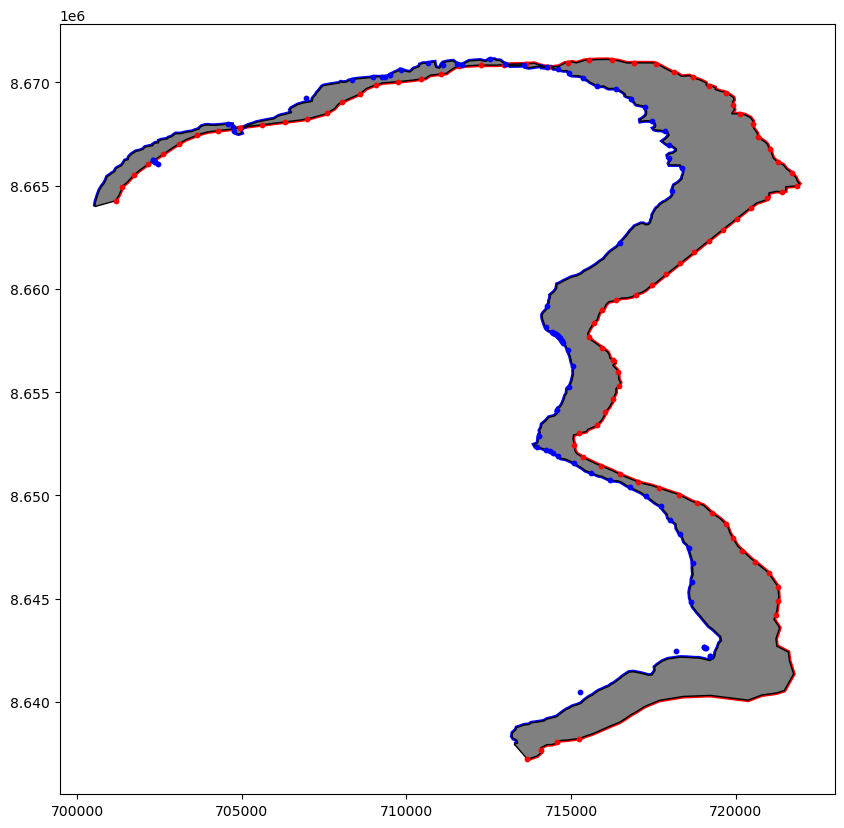

In [14]:
i1, i2 = 2, 3

front1, front2 = fronts_i.iloc[i1].geometry, fronts_i.iloc[i2].geometry
dir1, dir2 = fronts_i.iloc[i1].front_dir, fronts_i.iloc[i2].front_dir
u = np.array([1, 1]) / np.sqrt(2)

## absolute distance
points_1 = [shapely.Point(coords) for coords in front1.coords]
points_2 = [shapely.Point(coords) for coords in front2.coords]

if shapely.distance(points_1[0], points_2[0]) > shapely.distance(points_1[0], points_2[-1]):
    points_2 = points_2[::-1]
    front2 = shapely.LineString(points_2)
    
polygon = shapely.Polygon(list(front1.coords) + list(front2.coords[::-1]))
area = polygon.area
d = area / ((front1.length + front2.length) / 2)
print("area :", area, "distance :", d)

## direction
# middle of extreme points → not working
# c1 = (np.array(front1.coords)[0] + np.array(front1.coords)[-1])/2
# c2 = (np.array(front2.coords)[0] + np.array(front2.coords)[-1])/2

# centroids → works but a lot of rejections
# c1 = np.array([shapely.centroid(front1).x, shapely.centroid(front1).y])
# c2 = np.array([shapely.centroid(front2).x, shapely.centroid(front2).y])

# center of the font → not working well
# c1 = np.array([front1.interpolate(0.5 * front1.length).x, front1.interpolate(0.5 * front1.length).y])
# c2 = np.array([front2.interpolate(0.5 * front2.length).x, front2.interpolate(0.5 * front2.length).y])

# dot_prod = np.dot(c2-c1, u)#/ np.linalg.norm(c2-c1)
# sgn = np.sign(dot_prod)
# print("dot product :", dot_prod, "sign :", sgn)

# center of the front1 + using flow direction → probably the best solution
points_interp_1 = pd.DataFrame(
    [],
    columns=["points", "x", "y"]
)
points_interp_1.loc[:, "points"] = front1.interpolate(np.linspace(0, front1.length, 100))
points_interp_1.loc[:, ["x", "y"]] = np.stack([np.array([points_interp_1.points.iloc[i].x, points_interp_1.points.iloc[i].y]) for i in range(100)], axis=0)
ll = shapely.MultiLineString([np.stack([points_interp_1.loc[:, ["x", "y"]].iloc[i] - u * 50000, points_interp_1.loc[:, ["x", "y"]].iloc[i] + u * 50000])for i in range(100)])
points_interp_2 = pd.DataFrame(
    [],
    columns=["points", "x", "y"]
)
for i in range(len(points_interp_1)):
    l = ll.geoms[i]
    point_interp_2_i = shapely.intersection(front2, l)
    
    if point_interp_2_i.is_empty:
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [None, None, None]
        
    elif isinstance(point_interp_2_i, shapely.Point):
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]
    
    elif isinstance(point_interp_2_i, shapely.MultiPoint):
        point_interp_2_i = np.array([np.array([pt.x, pt.y]) for pt in point_interp_2_i.geoms]).mean(axis=0)
        point_interp_2_i = shapely.Point(point_interp_2_i)
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]

points_interp = pd.concat([points_interp_1, points_interp_2], axis=1)
points_interp.columns = ["points_1", "x1", "y1", "points_2", "x2", "y2"]
points_interp.dropna(inplace=True)

# points_interp
points_interp.loc[:, "x21"] = points_interp.loc[:, "x2"] - points_interp.loc[:, "x1"]
points_interp.loc[:, "y21"] = points_interp.loc[:, "y2"] - points_interp.loc[:, "y1"]
dot_prod = points_interp.loc[:, ["x21", "y21"]].apply(lambda z: z.x21 * u[0] + z.y21 * u[1], axis=1)
points_interp.loc[:, "dot_prod"] = dot_prod
sgn = np.sign(points_interp.dot_prod.mean())

print("distance from dot prod :", dot_prod.mean() , ", direction :", sgn)

## plots
fig, ax = plt.subplots(figsize=[10, 10])
shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_polygon(polygon, facecolor="gray", edgecolor="k", add_points=False, ax=ax)
ax.scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
ax.scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

## Box method

In [15]:
boxes = gpd.read_file(posixpath.join(data_root, "boxes/boxes.shp")).to_crs(epsg=25833)
boxes.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"POLYGON ((448958.093 8831407.133, 451132.965 8..."
1,2,NE,RGI60-07.00791,RGI2000-v7.0-G-07-01223,"POLYGON ((448556.464 8831393.624, 447609.196 8..."
2,3,E,RGI60-07.00777,RGI2000-v7.0-G-07-01225,"POLYGON ((446223.949 8833013.329, 449012.234 8..."
3,4,SE,RGI60-07.00775,RGI2000-v7.0-G-07-01229,"POLYGON ((445849.929 8838239.577, 448611.174 8..."
4,5,NE,RGI60-07.00794,RGI2000-v7.0-G-07-01268,"POLYGON ((444478.132 8842149.605, 443352.455 8..."


In [16]:
fronts_i = all_fronts.loc[all_fronts.front_id == 52]
fronts_i

,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry,image
51,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (485597.286 8714621.76, 485445.703 ...",NaN
199,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482907.211 8713010.646, 482911.001...",DS09058A024MC012
255,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482953.714 8712928.344, 483061.461...",DS09058A024MC013
417,KH-5 ARGON 9034A,1962-05-16,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (483353.81 8712332.201, 483280.998 ...",DS09034A008MC022
801,Landsat 2 MSS,1976-07-09,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482828.179 8713133.73, 482861.804 ...",LM02_L1GS_239002_19760709_20200907_02_T2
808,Landsat 2 MSS,1976-07-10,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482862.657 8713011.896, 482866.66 ...",LM02_L1GS_240002_19760710_20200907_02_T2
1007,Landsat 3 MSS,1978-08-12,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482704.683 8713062.28, 482768.992 ...",LM03_L1GS_238003_19780812_20210611_02_T2


[[ 487855.85190003 8713300.19571801]
 [ 481422.78938224 8711594.19018843]] [8713300.19571801 8711594.19018843]
Distance between fronts 1 and 4 is -584.09 m, with area1 = 3727731.88 m^2, area2 = 2738724.35 m^2, base length = 1693.25 m.


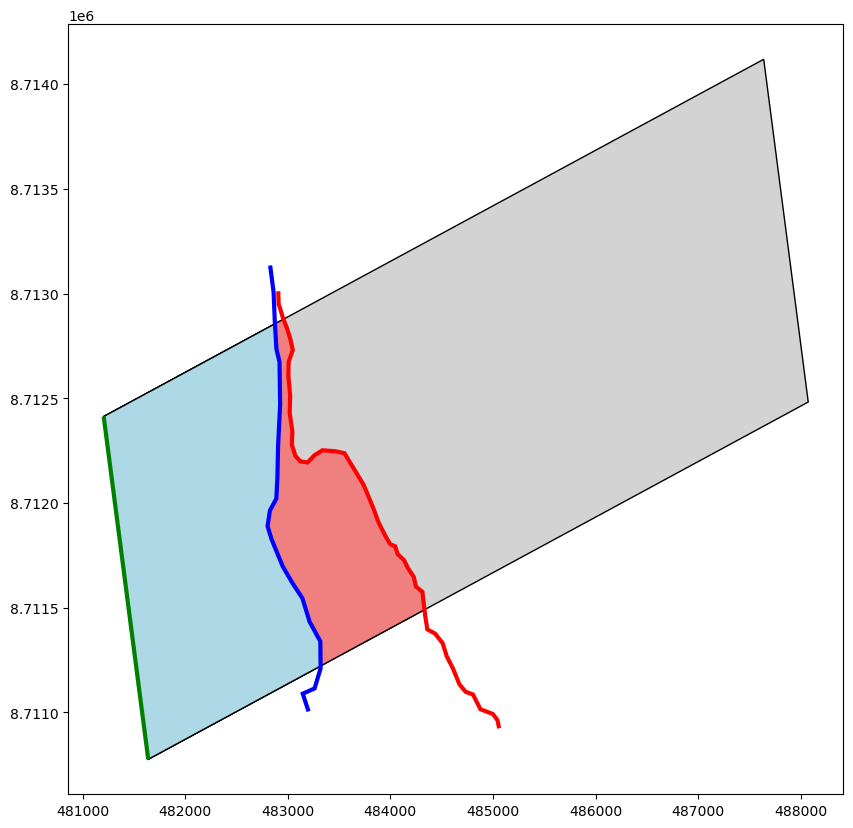

In [17]:
ia, ib = 1, 4

front1, front2 = fronts_i.iloc[ia].geometry, fronts_i.iloc[ib].geometry
dir1, dir2 = fronts_i.iloc[ia].front_dir, fronts_i.iloc[ib].front_dir
u = np.array([0, 1])
box = boxes.loc[boxes.front_id == fronts_i.iloc[ia].front_id].geometry.values[0]

inter1, inter2 = shapely.intersection(front1, box.exterior), shapely.intersection(front2, box.exterior)
if isinstance(inter1, shapely.Point):
    inter1 = shapely.MultiPoint([inter1])
if isinstance(inter2, shapely.Point):
    inter2 = shapely.MultiPoint([inter2])
    
assert(not inter1.is_empty), "Intersection of front 1 with the box is empty."
assert(not inter2.is_empty), "Intersection of front 2 with the box is empty."
    
assert(len(list(inter1.geoms)) >= 2), "Intersection of front 1 with the box should be a line."
assert(len(list(inter2.geoms)) >= 2), "Intersection of front 2 with the box should be a line."

# method 1 : dot product with points 1 by 1: doesn't work
# box_points = np.array([[shapely.Point(coords).x, shapely.Point(coords).y] for coords in box.exterior.coords])[:-1, :]
# u_dot_box = np.sum(box_points * np.stack([u, u, u, u], axis=0), axis=1)
# print(box_points)
# print(u_dot_box)

# i1 = np.argmin(u_dot_box, axis=0)
# u_dot_box_cpy = np.copy(u_dot_box)
# u_dot_box_cpy[i1] = np.inf
# i2 = np.argmin(u_dot_box_cpy, axis=0)

# base_points = np.stack([box_points[i1], box_points[i2]])


# method 2 : intersection with fronts + dot product with u: works!
box_sides = [shapely.LineString([box.exterior.coords[i], box.exterior.coords[i + 1]]) for i in range(len(box.exterior.coords) - 1)]
possible_base = [box_sides[i] for i in range(len(box_sides)) if not shapely.intersects(box_sides[i], front1)]
possible_base_centers = np.array([[shapely.centroid(possible_base[i]).x, shapely.centroid(possible_base[i]).y] for i in range(len(possible_base))])
u_dot_c = np.sum(possible_base_centers * np.stack([u, u], axis=0), axis=1)

base = possible_base[np.argmin(u_dot_c)]
print(possible_base_centers, u_dot_c)
# base_points = np.array([[shapely.Point(coords).x, shapely.Point(coords).y] for coords in base.coords])


# cropped fronts
front1_crop = shapely.intersection(front1, box)
front2_crop = shapely.intersection(front2, box)

if isinstance(front1_crop, shapely.MultiLineString):
    lines = [shapely.LineString(line) for line in front1_crop.geoms]
    front1_crop = lines[np.argmax([line.length for line in lines])]
if isinstance(front2_crop, shapely.MultiLineString):
    lines = [shapely.LineString(line) for line in front2_crop.geoms]
    front2_crop = lines[np.argmax([line.length for line in lines])]

# distance
points_1 = [shapely.Point(coords) for coords in front1_crop.coords]
points_2 = [shapely.Point(coords) for coords in front2_crop.coords]
base_points = [shapely.Point(coords) for coords in base.coords]

if shapely.distance(points_1[0], base_points[0]) > shapely.distance(points_1[0], base_points[-1]):
    points_1 = points_1[::-1]
    front1_crop = shapely.LineString(points_1)
    
if shapely.distance(points_2[0], base_points[0]) > shapely.distance(points_2[0], base_points[-1]):
    points_2 = points_2[::-1]
    front2_crop = shapely.LineString(points_2)
    
polygon1 = shapely.Polygon(list(front1_crop.coords) + list(base.coords[::-1]))
polygon2 = shapely.Polygon(list(front2_crop.coords) + list(base.coords[::-1]))
area1 = polygon1.area
area2 = polygon2.area
d = (area2 - area1)/base.length

print(f"Distance between fronts {ia} and {ib} is {d:.2f} m, with area1 = {area1:.2f} m^2, area2 = {area2:.2f} m^2, base length = {base.length:.2f} m.")


## plots
fig, ax = plt.subplots(figsize=[10, 10])
shapely.plotting.plot_polygon(box, facecolor="lightgray", edgecolor="k", add_points=False, ax=ax)
shapely.plotting.plot_polygon(polygon1, facecolor="lightcoral", edgecolor="k", add_points=False, ax=ax)
shapely.plotting.plot_polygon(polygon2, facecolor="lightblue", edgecolor="k", add_points=False, ax=ax)
shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(base, color="green", add_points=False, linewidth=3, ax=ax)
# shapely.plotting.plot_line(possible_base[0], color="orange", add_points=False, linewidth=3, ax=ax)
# shapely.plotting.plot_line(possible_base[1], color="orange", add_points=False, linewidth=3, ax=ax)
# ax.scatter(possible_base_centers[:, 0], possible_base_centers[:, 1], color="black", s=10, label="possible base centers")

## Curvilinear centerline method

In [18]:
centerlines = gpd.read_file(posixpath.join(data_root, "centerlines/centerlines.shp"), columns=["front_id", "geometry"]).to_crs(epsg=25833).dropna()
centerlines.columns = ["front_id_float", "geometry"]
centerlines.loc[:, "front_id"] = centerlines.front_id_float.astype(int)
centerlines = centerlines.loc[:, ["front_id", "geometry"]]
centerlines

,front_id,geometry
0,73,"LINESTRING (534321.434 8546768.732, 534362.547..."
1,68,"LINESTRING (521713.665 8552295.499, 521056.825..."
2,61,"LINESTRING (522358.058 8605537.509, 522635.212..."
3,96,"LINESTRING (560900.741 8615217.504, 561141.212..."
4,1,"LINESTRING (449615.704 8824196.706, 449565.438..."
...,...,...
171,174,"LINESTRING (662413.303 8904509.794, 662501.881..."
172,176,"LINESTRING (623057.501 8902129.534, 623270.469..."
173,175,"LINESTRING (627752.808 8900059.034, 627524.252..."
174,177,"LINESTRING (607756.995 8909417.042, 607773.696..."


In [19]:
fronts_i = all_fronts.loc[all_fronts.front_id == 61]
fronts_i

,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry,image
39,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00235,RGI2000-v7.0-G-07-00899,61,NW,"LINESTRING (526263.036 8601073.113, 526289.399...",NaN
639,KH-5 ARGON 9034A,1962-05-16,RGI60-07.00235,RGI2000-v7.0-G-07-00899,61,NW,"LINESTRING (529804.91 8595438.434, 529837.991 ...",DS09034A008MC022
640,KH-5 ARGON 9034A,1962-05-16,RGI60-07.00235,RGI2000-v7.0-G-07-00899,61,NW,"LINESTRING (529878.788 8595135.878, 529985.59 ...",DS09034A008MC020
641,KH-5 ARGON 9034A,1962-05-16,RGI60-07.00235,RGI2000-v7.0-G-07-00899,61,NW,"LINESTRING (529915.099 8594888.269, 530005.95 ...",DS09034A008MC021
1145,Landsat 2 MSS,1976-07-18,RGI60-07.00322,RGI2000-v7.0-G-07-00913,61,NW,"LINESTRING (530103.555 8594069.517, 530116.87 ...",LM02_L1GS_230004_19760718_20200907_02_T2
1146,Landsat 2 MSS,1978-09-22,RGI60-07.00322,RGI2000-v7.0-G-07-00913,61,NW,"LINESTRING (530269.74 8593253.504, 530332.717 ...",LM02_L1GS_234004_19780922_20210610_02_T2


Distance:  -3667.5128604892734


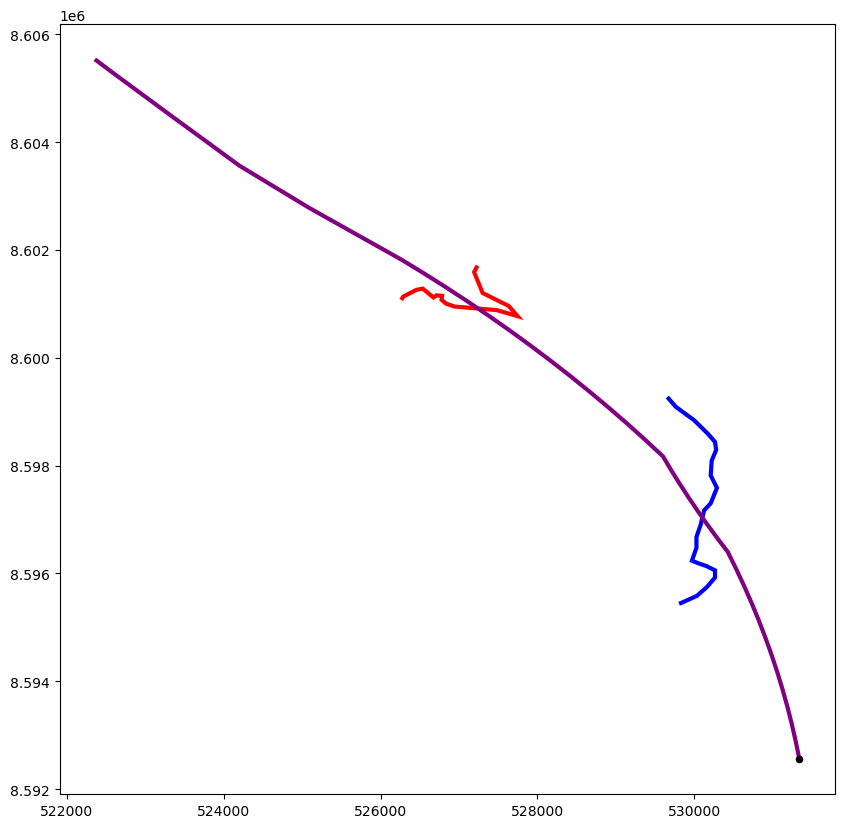

In [20]:
ia, ib = 0, 1

front1, front2 = fronts_i.iloc[ia].geometry, fronts_i.iloc[ib].geometry
dir1, dir2 = fronts_i.iloc[ia].front_dir, fronts_i.iloc[ib].front_dir
u = np.array([-1, 1])/np.sqrt(2)
cl = centerlines.loc[centerlines.front_id == fronts_i.iloc[ia].front_id].geometry.values[0]

assert(shapely.intersects(front1, cl)), "Front 1 does not intersect with the centerline."
assert(shapely.intersects(front2, cl)), "Front 2 does not intersect with the centerline."

# points_cl = [shapely.Point(pt) for pt in cl.coords]
points_cl = shapely.get_coordinates(cl)

## orient the centerline such that the the origin is upflow
if np.dot(points_cl[-1, :], u) < np.dot(points_cl[0], u):
    cl = cl.reverse()
    points_cl = shapely.get_coordinates(cl)

## define curvilinear abscissa
x = np.array([0] + [shapely.LineString(points_cl[0:i + 1, :]).length for i in range(1, points_cl.shape[0])]) # curvilinear abscissa of all the points along the centerline

## weights
p = 2
points1 = shapely.get_coordinates(front1)
cl1_mesh_0, f1_mesh_0 = np.meshgrid(points_cl[:, 0], points1[:, 0], indexing="ij")
cl1_mesh_1, f1_mesh_1 = np.meshgrid(points_cl[:, 1], points1[:, 1], indexing="ij")
cl1_mesh, f1_mesh = np.stack([cl1_mesh_0, cl1_mesh_1], axis=-1), np.stack([f1_mesh_0, f1_mesh_1], axis=-1)
w1 = 1 / np.sum(np.abs(cl1_mesh - f1_mesh)** p, axis=-1) ** (1/p)
w1 = w1 / np.sum(w1, axis=0)  # normalize weights

x1_mesh = np.stack([x for _ in range(points1.shape[0])], axis=1)
t1 = np.sum(x1_mesh * w1, axis=0)
T1 = t1.mean()

points2 = shapely.get_coordinates(front2)
cl2_mesh_0, f2_mesh_0 = np.meshgrid(points_cl[:, 0], points2[:, 0], indexing="ij")
cl2_mesh_1, f2_mesh_1 = np.meshgrid(points_cl[:, 1], points2[:, 1], indexing="ij")
cl2_mesh, f2_mesh = np.stack([cl2_mesh_0, cl2_mesh_1], axis=-1), np.stack([f2_mesh_0, f2_mesh_1], axis=-1)
w2 = 1 / np.sum(np.abs(cl2_mesh - f2_mesh)** p, axis=-1) ** (1/p)
w2 = w2 / np.sum(w2, axis=0)  # normalize weights

x2_mesh = np.stack([x for _ in range(points2.shape[0])], axis=1)
t2 = np.sum(x2_mesh * w2, axis=0)
T2 = t2.mean()

print("Distance: ", T2 - T1)

    
## plots
fig, ax = plt.subplots(figsize=[10, 10])
shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(cl, color="purple", add_points=False, linewidth=3, ax=ax)
ax.scatter(points_cl[0, 0], points_cl[0, 1], color="black", s=20, label="origin")